In [1]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize
from matplotlib import style
from scipy.stats import skew, kurtosis

import matplotlib
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16)
FIGURE_PATH = "./figures/"

/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


### a)

In [2]:
df = pd.read_excel("data/sv.xlsx")
df.head()

,GBPUSD
0,-0.355532
1,1.425409
2,-0.443940
3,1.025650
4,1.677579


In [3]:
df['returns'] = df['GBPUSD']/100
print(df['returns'].describe())
print('skewness:', skew(df['returns']))
print('kurtosis:', kurtosis(df['returns']))
df

count    945.000000
mean      -0.000353
std        0.007111
min       -0.032961
25%       -0.004394
50%       -0.000457
75%        0.003644
max        0.045345
Name: returns, dtype: float64
skewness: 0.6041771319562368
kurtosis: 4.8619099904534755


,GBPUSD,returns
0,-0.355532,-0.003555
1,1.425409,0.014254
2,-0.443940,-0.004439
3,1.025650,0.010257
4,1.677579,0.016776
...,...,...
940,0.428767,0.004288
941,-0.093392,-0.000934
942,0.891444,0.008914
943,-0.945963,-0.009460


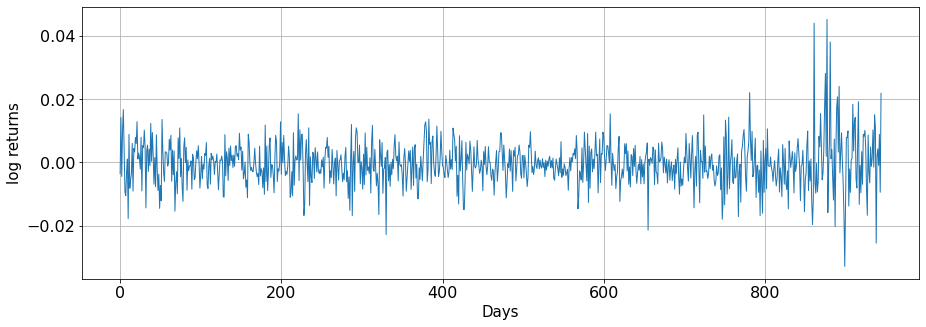

In [4]:
plt.figure(figsize=(15,5))
plt.plot(df['returns'], linewidth= 1)
plt.grid()
plt.xlabel('Days', fontsize = 15)
plt.ylabel('log returns', fontsize = 15)
plt.savefig(FIGURE_PATH + 'fig2.1.png')
plt.show()


### b)

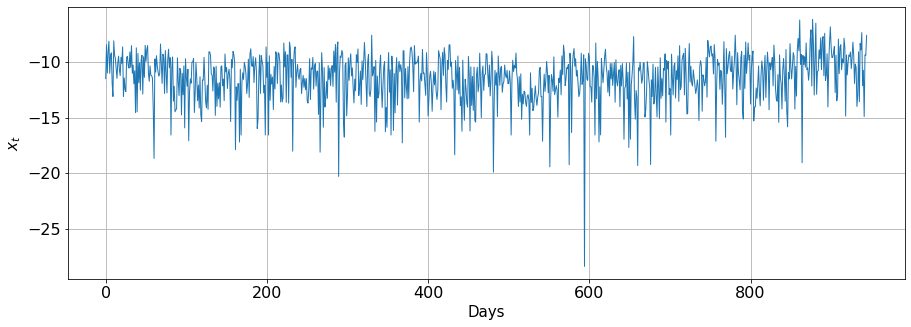

In [5]:
df['xt'] = np.log((df['returns'] - df['returns'].mean())**2)
plt.figure(figsize=(15,5))
plt.grid()
plt.plot(df['xt'], linewidth = 1)
plt.xlabel('Days', fontsize = 15)
plt.ylabel(r'$x_t$ ', fontsize = 15)
plt.savefig(FIGURE_PATH + 'fig2.2.png')
plt.show()

In [6]:
df

,GBPUSD,returns,xt
0,-0.355532,-0.003555,-11.487826
1,1.425409,0.014254,-8.452482
2,-0.443940,-0.004439,-11.000233
3,1.025650,0.010257,-9.091992
4,1.677579,0.016776,-8.133977
...,...,...,...
940,0.428767,0.004288,-10.745749
941,-0.093392,-0.000934,-14.902131
942,0.891444,0.008914,-9.362474
943,-0.945963,-0.009460,-9.397527


### c)

In [7]:

# Define the linearized model parameters
phi = 0.995
omega = (1 - phi) * (df['xt'].mean() + 1.27)
s2_eta = (1 - phi) * (np.var(df['xt']) - np.pi**2/2)

# Define the initial state variables and their covariance
a0 = omega / (1 - phi)
P0 = s2_eta / (1 - phi**2)

# Define the observation matrix and covariance
H = np.pi**2/2

# Define the likelihood function
def likelihood(params, a0, P0, y, H):
    omega, phi, s2_eta = params
    n_obs = y.shape[0]
    loglik = 0
    a = a0
    P = P0
    d = -1.27
    c = omega
    T = phi
    Q = s2_eta
    for t in range(n_obs):
        v = y[t] - a - d
        F = P + H
        K = T * P * F**-1

        a = T * a + K * v + c
        P = T**2 * P  + Q -  F * K**2

        # Compute the log-likelihood contribution for this time step
        loglik += -0.5 * (np.log(2 * np.pi) + np.log(abs(F)) + v**2 / F)

    return -loglik

params0 = [omega, phi, s2_eta]
bounds = ((None, None), (0, 1), (0, None))
res = minimize(fun=likelihood, x0=params0, args=(a0, P0, df['xt'], H), bounds=bounds, options={'maxiter':5000})
  
omega_hat, phi_hat, s2_eta_hat = res.x
print(res.x)


[-0.10045639  0.99006818  0.00741708]


### d)

In [8]:
def kalman_filter(params, y):
    omega, phi, s2_eta = params
    n_obs = y.shape[0]
    a0 = omega / (1 - phi)
    P0 = s2_eta / (1 - phi**2) 
    a = a0
    P = P0
    d = -1.27
    c = omega
    T = phi
    Q = s2_eta
    H = np.pi**2/2

    df_kf = pd.DataFrame(columns=['a_filter', 'P', 'v', 'F', 'K'])

    for t in range(n_obs):
        v = y[t] - a - d
        F = P + H
        K = T * P * F**-1

        df_kf.loc[t] = [a, P, v, F, K]

        a = T * a + K * v + c
        P = T**2 * P  + Q -  F * K**2
      
    xi = params[0] / (1 - params[1])
    df_kf['h_filter'] = df_kf['a_filter'] - xi

    return df_kf

df_kf = kalman_filter(res.x, df['xt'])
df_kf

,a_filter,P,v,F,K,h_filter
0,-10.114597,0.375263,-0.103229,5.310066,0.069968,0.000000
1,-10.121819,0.349268,2.939337,5.284070,0.065442,-0.007223
2,-9.929392,0.327152,0.199160,5.261954,0.061556,0.185204
3,-9.918972,0.308165,2.096981,5.242967,0.058193,0.195624
4,-9.798886,0.291736,2.934908,5.226538,0.055264,0.315711
...,...,...,...,...,...,...
940,-9.244268,0.151491,-0.231481,5.086293,0.029488,0.870329
941,-9.259738,0.151491,-4.372394,5.086293,0.029488,0.854859
942,-9.397163,0.151491,1.304689,5.086293,0.029488,0.717434
943,-9.365815,0.151491,1.238288,5.086293,0.029488,0.748782


In [9]:
def kalman_smoother(params, y):
    df_kf = kalman_filter(params, y)
    df_kf = df_kf.iloc[::-1].reset_index(drop=True)
    df_ks = pd.DataFrame(columns=['r', 'a_smoother', 'N', 'V'])
    n_obs = y.shape[0]
    r = 0
    N = 0
    omega, phi, s2_eta = params

    for t in range(n_obs):
        
        r = df_kf['F'][t]**-1 * df_kf['v'][t] + (phi-df_kf['K'][t])*r
        N = df_kf['F'][t]**-1 + (phi-df_kf['K'][t])**2 * N

        a = df_kf['a_filter'][t] + df_kf['P'][t]*r
        V = df_kf['P'][t] - df_kf['P'][t]**2 * N

        df_ks.loc[t] = [r, a, N, V]

    df_ks = df_ks.iloc[::-1].reset_index(drop=True)
    uncon_mean = params[0] / (1 - params[1])
    df_ks['h_smoother'] = df_ks['a_smoother'] - uncon_mean
    return df_ks    

df_ks = kalman_smoother(res.x, df['xt'])
df_ks

,r,a_smoother,N,V,h_smoother
0,1.823059,-9.430470,1.621077,0.146979,0.684127
1,2.002499,-9.422412,1.692397,0.142816,0.692185
2,1.564129,-9.417685,1.758204,0.138974,0.696912
3,1.643790,-9.412414,1.818926,0.135430,0.702182
4,1.334760,-9.409488,1.874954,0.132159,0.705108
...,...,...,...,...,...
940,0.082500,-9.231770,0.842381,0.132159,0.882827
941,0.133264,-9.239549,0.699864,0.135430,0.875047
942,1.033654,-9.240573,0.545410,0.138974,0.874023
943,0.809035,-9.243253,0.378019,0.142816,0.871343


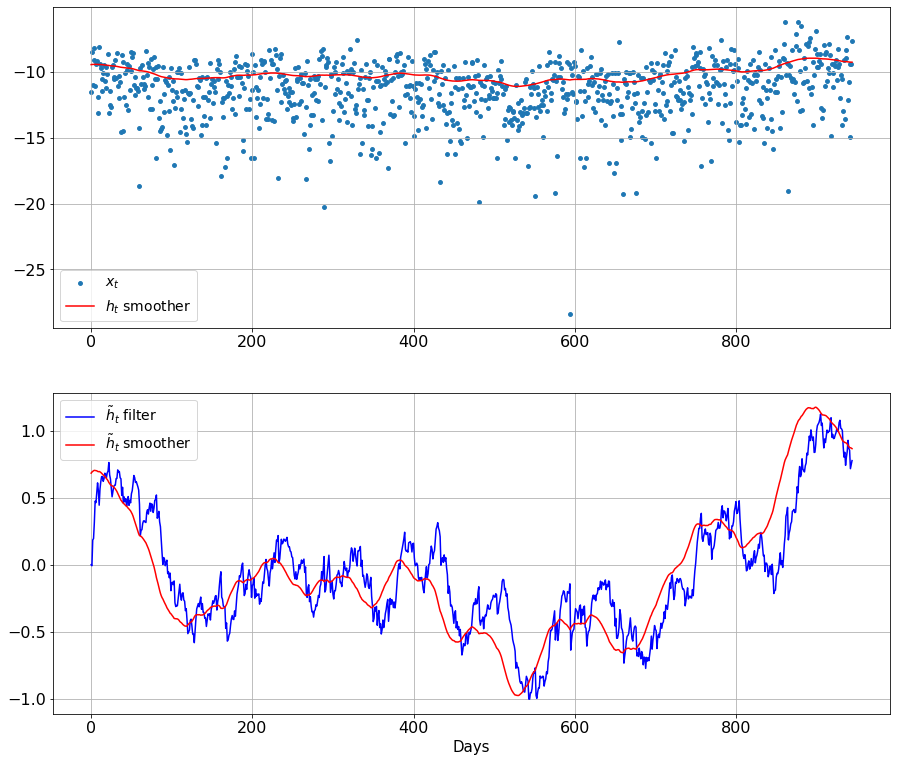

In [10]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper left
ax = axs[0]

ax.scatter(df.index, df.xt, s=15, label = r'$x_t$')
# ax.plot(df.index, df_kf.a_filter, color = 'b', label = r'$h_t$ filter')
ax.plot(df.index, df_ks.a_smoother, color = 'r', label = r"$h_t$ smoother")
ax.legend(fontsize = 14)

ax = axs[1]
ax.plot(df.index, df_kf.h_filter, color = 'b', label = r"$\tilde{h}_t$ filter")
ax.plot(df.index, df_ks.h_smoother, color = 'r', label = r"$\tilde{h}_t$ smoother" )
ax.set_xlabel('Days', fontsize = 15)
ax.legend(fontsize = 14)

for ax in axs:
    ax.grid()
    pass

plt.savefig(FIGURE_PATH + 'fig2.3.png')
plt.show()

### e) (part 1)

In [11]:
tickers = ['^GSPC', 'AAPL']
start_date = '2016-02-09'
end_date = '2021-02-11'

data = yf.download(tickers, start=start_date, end=end_date)

# Extract the adjusted close prices for the tickers
adj_close = data['Adj Close']

# Calculate the daily returns for the tickers
daily_returns = adj_close.pct_change()

df_tick = pd.DataFrame(daily_returns).reset_index()[1:]
df_tick = df_tick.rename(columns={'^GSPC': 'sp'})
df_tick['xt'] = np.log((df_tick.sp - df_tick.sp.mean())**2)
df_tick = df_tick.reset_index(drop=True)
df_tick

[*********************100%***********************]  2 of 2 completed


,Date,AAPL,sp,xt
0,2016-02-10,-0.007579,-0.000189,-14.129266
1,2016-02-11,-0.006047,-0.012301,-8.690692
2,2016-02-12,0.003095,0.019518,-7.942252
3,2016-02-16,0.028194,0.016517,-8.289071
4,2016-02-17,0.015315,0.016480,-8.293646
...,...,...,...,...
1255,2021-02-04,0.025758,0.010853,-9.173195
1256,2021-02-05,-0.003098,0.003897,-11.469533
1257,2021-02-08,0.001097,0.007399,-10.001323
1258,2021-02-09,-0.006574,-0.001114,-12.662977


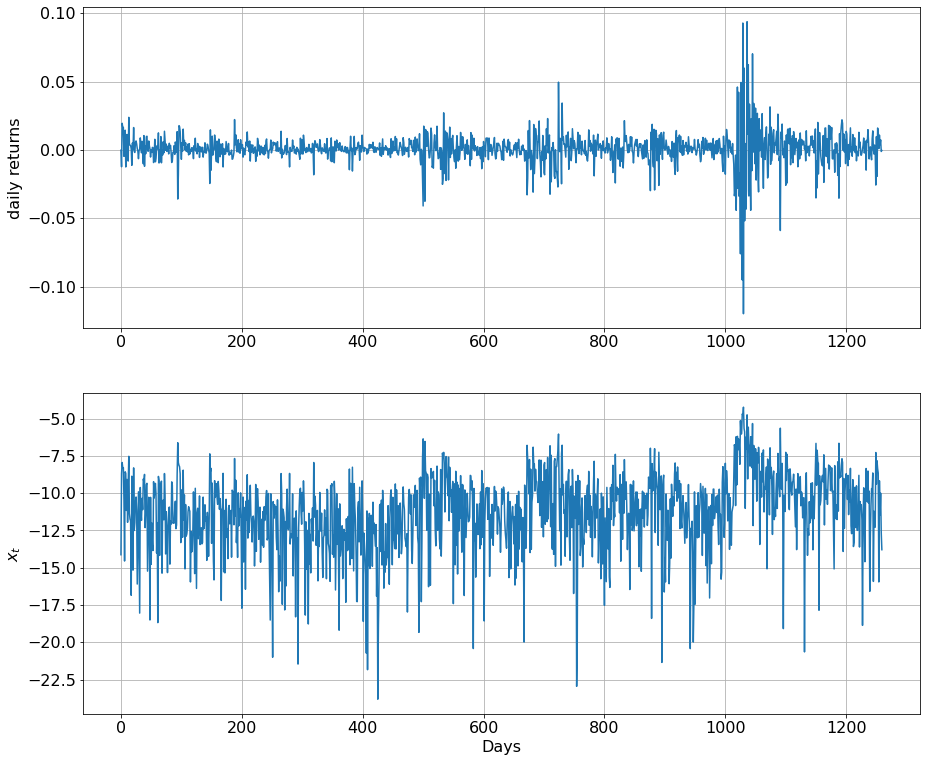

In [12]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper left
ax = axs[0]

ax.plot(df_tick.index, df_tick.sp)
ax.set_ylabel('daily returns', fontsize=16)

ax = axs[1]
ax.plot(df_tick.index, df_tick.xt)
ax.set_ylabel(r'$x_t$', fontsize=16)
ax.set_xlabel('Days', fontsize=16)

for ax in axs:
    ax.grid()
    pass

plt.savefig(FIGURE_PATH + 'fig2.e1.png')
plt.show()

In [13]:
# Define the linearized model parameters
phi = 0.995
omega = (1 - phi) * (df_tick['xt'].mean() + 1.27)
s2_eta = (1 - phi) * (np.var(df_tick['xt']) - np.pi**2/2)

# Define the initial state variables and their covariance
a0 = omega / (1 - phi)
P0 = s2_eta / (1 - phi**2)

# Define the observation matrix and covariance
H = np.pi**2/2

# Define the likelihood function
def likelihood(params, a0, P0, y, H):
    omega, phi, s2_eta = params
    n_obs = y.shape[0]
    loglik = 0
    a = a0
    P = P0
    d = -1.27
    c = omega
    T = phi
    Q = s2_eta
    for t in range(n_obs):
        v = y[t] - a - d
        F = P + H
        K = T * P * F**-1

        a = T * a + K * v + c
        P = T**2 * P  + Q -  F * K**2

        # Compute the log-likelihood contribution for this time step
        loglik += -0.5 * (np.log(2 * np.pi) + np.log(abs(F)) + v**2 / F)

    return -loglik

params0 = [omega, phi, s2_eta]
bounds = ((None, None), (0, 1), (0, None))
res_e = minimize(fun=likelihood, x0=params0, args=(a0, P0, df_tick['xt'], H), bounds=bounds, options={'maxiter':5000})
  
omega_hat, phi_hat, s2_eta_hat = res_e.x

print(res_e.x)


[-0.30014286  0.97019816  0.1052841 ]


In [14]:
df_kf_1 = kalman_filter(res_e.x, df_tick['xt'])
df_ks = kalman_smoother(res_e.x, df_tick['xt'])

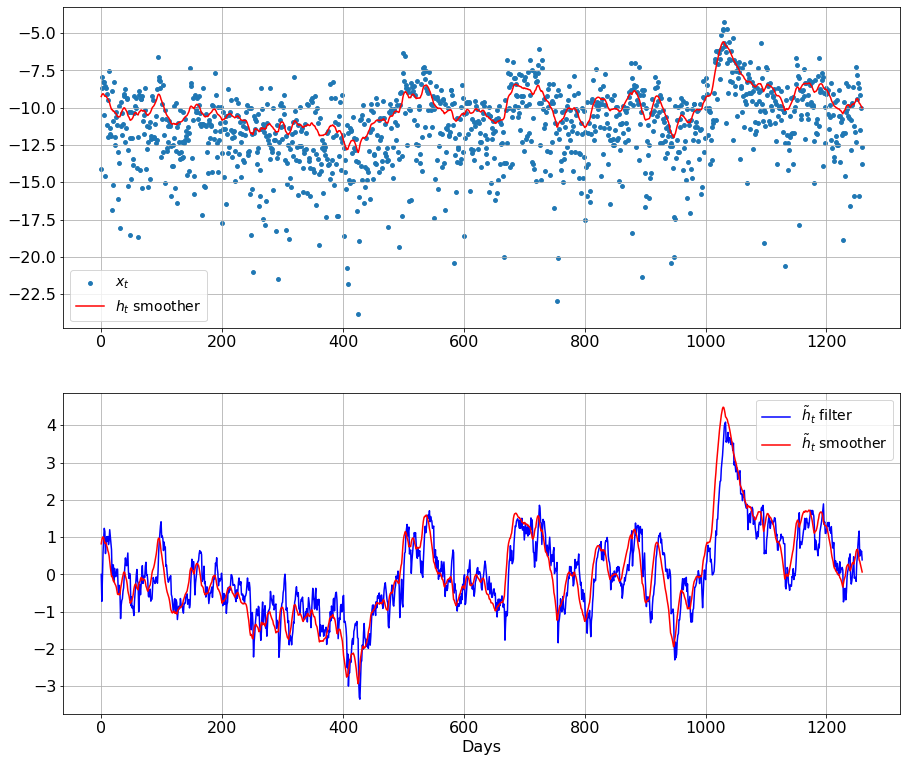

In [15]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper left
ax = axs[0]

ax.scatter(df_tick.index, df_tick.xt, s=15, label = r'$x_t$')
# ax.plot(df_tick.index, df_kf_1.a_filter, color = 'b', label = r'$h_t$ filter')
ax.plot(df_tick.index, df_ks.a_smoother, color = 'r', label = r"$h_t$ smoother")
ax.legend(fontsize = 14)

ax = axs[1]
ax.plot(df_tick.index, df_kf_1.h_filter, color = 'b', label = r"$\tilde{h}_t$ filter")
ax.plot(df_tick.index, df_ks.h_smoother, color = 'r', label = r"$\tilde{h}_t$ smoother" )
ax.set_xlabel('Days', fontsize=16)
ax.legend(fontsize = 14)

for ax in axs:
    ax.grid()
    pass

plt.savefig(FIGURE_PATH + 'fig2.e2.png', dpi=300)
plt.show()

### e) part 2

In [89]:
df_rv = pd.read_csv('data/realized_volatility.csv')
df_rv = df_rv[(df_rv['Symbol'] == '.SPX')].reset_index(drop=True)
df_rv['date'] = pd.to_datetime(df_rv['date'])
df_rv = df_rv[df_rv.date >= pd.to_datetime('2016-02-10 00:00:00+00:00')].reset_index(drop=True)
df_rv = df_rv[['date', 'Symbol', 'rv5']]
df_rv['xt'] = df_tick['xt']
df_rv['rv_adj'] = np.log(df_rv['rv5']) - 1.27
df_kf_1 = kalman_filter(res_e.x, df_rv['xt'])
df_kf_2 = kalman_filter(res_e.x, df_rv['rv_adj'])
beta = (sum(df_kf_2.v * df_kf_1.F**-1  * df_kf_2.v))**-1 * sum(df_kf_2.v * (df_kf_1.F**-1) * df_kf_1.v)
df_rv['xt_adj'] = df_rv['xt'] - beta * np.log(df_rv['rv5'])
df_rv

,date,Symbol,rv5,xt,rv_adj,xt_adj
0,2016-02-10 00:00:00+00:00,.SPX,0.000165,-14.129266,-9.979408,-7.891384
1,2016-02-11 00:00:00+00:00,.SPX,0.000305,-8.690692,-9.365040,-2.892835
2,2016-02-12 00:00:00+00:00,.SPX,0.000097,-7.942252,-10.511011,-1.323624
3,2016-02-16 00:00:00+00:00,.SPX,0.000093,-8.289071,-10.557964,-1.636813
4,2016-02-17 00:00:00+00:00,.SPX,0.000073,-8.293646,-10.788903,-1.475984
...,...,...,...,...,...,...
1245,2021-02-04 00:00:00+00:00,.SPX,0.000020,-15.920105,-12.077224,-8.179718
1246,2021-02-05 00:00:00+00:00,.SPX,0.000023,-11.211605,-11.970449,-3.547692
1247,2021-02-08 00:00:00+00:00,.SPX,0.000022,-11.651913,-11.980094,-3.981093
1248,2021-02-09 00:00:00+00:00,.SPX,0.000009,-12.280215,-12.846193,-3.989074


In [90]:
# Define the linearized model parameters
phi = 0.995
omega = (1 - phi) * (df_rv['xt_adj'].mean() + 1.27)
s2_eta = (1 - phi) * (np.var(df_rv['xt_adj']) - np.pi**2/2)

# Define the initial state variables and their covariance
a0 = omega / (1 - phi)
P0 = s2_eta / (1 - phi**2)

# Define the observation matrix and covariance
H = np.pi**2/2

# Define the likelihood function
def likelihood(params, a0, P0, y, H):
    omega, phi, s2_eta = params
    n_obs = y.shape[0]
    loglik = 0
    a = a0
    P = P0
    d = -1.27
    c = omega
    T = phi
    Q = s2_eta
    for t in range(n_obs):
        v = y[t] - a - d
        F = P + H
        K = T * P * F**-1

        a = T * a + K * v + c
        P = T**2 * P  + Q -  F * K**2

        # Compute the log-likelihood contribution for this time step
        loglik += -0.5 * (np.log(2 * np.pi) + np.log(abs(F)) + v**2 / F)

    return -loglik

params0 = [omega, phi, s2_eta]
bounds = ((None, None), (0, 1), (0, None))
res_e2 = minimize(fun=likelihood, x0=params0, args=(a0, P0, df_rv['xt_adj'], H), bounds=bounds, options={'maxiter':5000})
  
omega_hat, phi_hat, s2_eta_hat = res_e2.x
print(res_e2.x, beta)


[-0.04634426  0.98184224  0.01087638] 0.7162234371285104


In [91]:
df_kf3 = kalman_filter(res_e2.x, df_rv['xt_adj'])
df_ks3 = kalman_smoother(res_e2.x, df_rv['xt_adj'])

In [92]:
df_kf3

,a_filter,P,v,F,K,h_filter
0,-2.552311,0.302241,-4.069073,5.237043,0.056664,0.000000
1,-2.782882,0.285426,1.160047,5.220228,0.053684,-0.230571
2,-2.716419,0.270986,2.662795,5.205788,0.051110,-0.164108
3,-2.577345,0.258512,2.210532,5.193315,0.048874,-0.025034
4,-2.468853,0.247681,2.262869,5.182483,0.046924,0.083458
...,...,...,...,...,...,...
1245,-2.559678,0.162859,-4.350040,5.097661,0.031368,-0.007367
1246,-2.695995,0.162859,0.418303,5.097661,0.031368,-0.143684
1247,-2.680264,0.162859,-0.030828,5.097661,0.031368,-0.127953
1248,-2.678908,0.162859,-0.040166,5.097661,0.031368,-0.126597


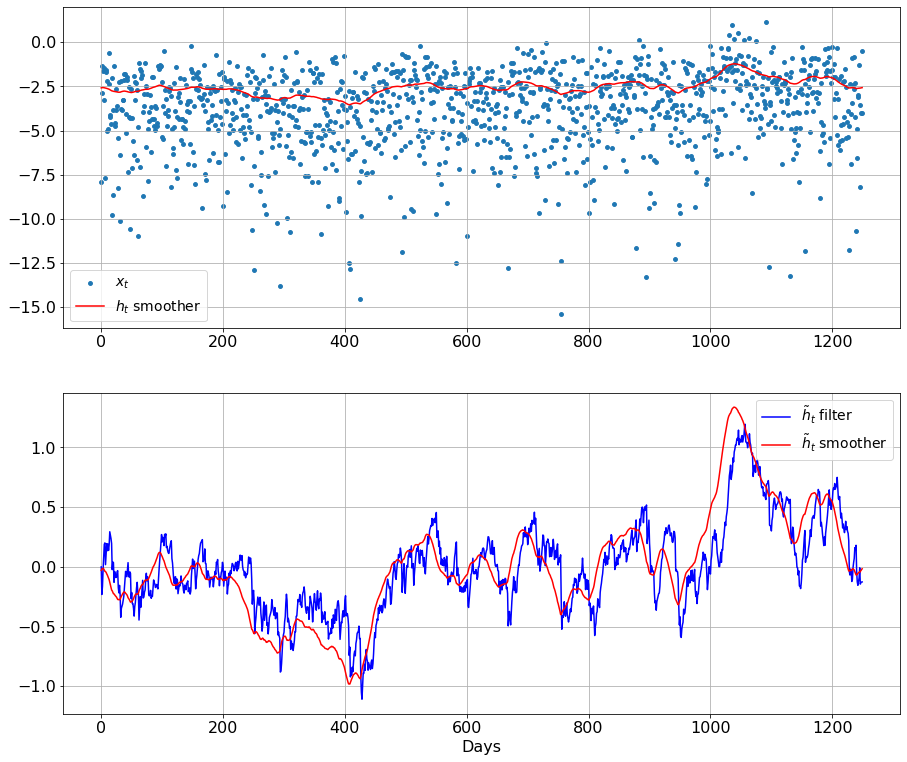

In [93]:
fig, axs = plt.subplots(2,1, figsize=(15,13))

# upper left
ax = axs[0]

ax.scatter(df_rv.index, df_rv.xt_adj, s=15, label = r'$x_t$')
# ax.plot(df_kf3.index, df_kf3.a_filter, color = 'b', label = r'$h_t$ filter')
ax.plot(df_kf3.index, df_ks3.a_smoother, color = 'r', label = r"$h_t$ smoother")
ax.legend(fontsize = 14)

ax = axs[1]
ax.plot(df_kf3.index, df_kf3.h_filter, color = 'b', label = r"$\tilde{h}_t$ filter")
ax.plot(df_kf3.index, df_ks3.h_smoother, color = 'r', label = r"$\tilde{h}_t$ smoother" )
ax.set_xlabel('Days', fontsize=16)
ax.legend(fontsize = 14)

for ax in axs:
    ax.grid()
    pass

plt.savefig(FIGURE_PATH+ 'fig2.e3.png', dpi=300)
plt.show()

### f)

In [16]:
def bootstrap_filter(params, N, y, k):

    omega, phi, s2_eta = params
    n_obs = y.shape[0]
    s2 = s2_eta / (1-phi**2)
    xi = omega / (1-phi)

    df_bs = pd.DataFrame(columns=['a_bootstrap'])

    for t in range(n_obs):
        #step 1
        if t == 0:
            alpha_t = np.random.randn(N) * s2**0.5
        else:
            alpha_t = np.random.randn(N) * s2_eta**0.5 + phi*alpha_t
        #step 2
        weight_t = np.exp(-0.5*(np.log(2*np.pi) + (xi + alpha_t) + (y[t]-y.mean())**2 / np.exp(xi + alpha_t)))
        weight_t /= sum(weight_t)
        #step 3
        a_t = np.dot(weight_t,alpha_t)
        #step 4
        if sum(weight_t**2)**-1 < k*N or True:
            alpha_t = np.random.choice(alpha_t, size=len(alpha_t), replace=True, p=weight_t)
            # print("resampling at %f" % t)
        df_bs.loc[t] = [a_t]

    return df_bs

df_bs = bootstrap_filter(params=res.x, N=10000, y=df['returns'], k=0.75)
df_bs


,a_bootstrap
0,-0.115581
1,0.411511
2,0.330941
3,0.425153
4,0.702739
...,...
940,0.936184
941,0.877442
942,0.861061
943,0.845507


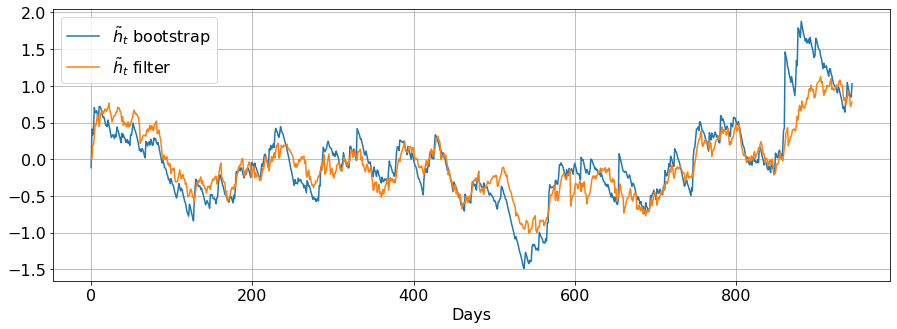

In [17]:
plt.figure(figsize=(15,5))
plt.plot(df_bs.a_bootstrap, label=r'$\tilde{h}_t$ bootstrap')
plt.plot(df_kf.h_filter, label=r'$\tilde{h}_t$ filter')
plt.grid()
plt.legend(fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.savefig(FIGURE_PATH + 'fig2.f1.png', dpi=300)
plt.show()

NameError: name 'FIGURE_PATH' is not defined

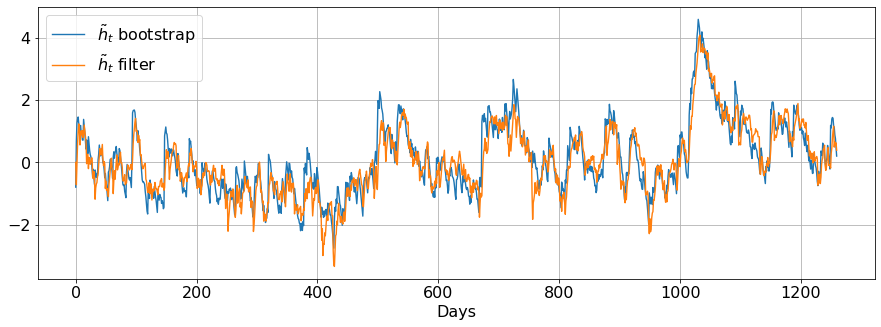

In [156]:
df_bs = bootstrap_filter(params=res_e.x, N=10000, y=df_tick['sp'], k=0.5)
plt.figure(figsize=(15,5))
plt.plot(df_bs.a_bootstrap, linewidth=1.4, label=r'$\tilde{h}_t$ bootstrap')
plt.plot(df_kf_1.h_filter, linewidth=1.4, label=r'$\tilde{h}_t$ filter')
plt.grid()
plt.legend(fontsize=16)
plt.xlabel('Days', fontsize=16)
plt.savefig(FIGURE_PATH + 'fig2.f2.png', dpi=300)
plt.show()

In [98]:
df_bs.shape, df_kf_1.shape

((1260, 1), (1250, 6))

In [88]:
df_tick["sp"]

0      -0.000189
1      -0.012301
2       0.019518
3       0.016517
4       0.016480
          ...   
1255    0.010853
1256    0.003897
1257    0.007399
1258   -0.001114
1259   -0.000345
Name: sp, Length: 1260, dtype: float64